# The Artistic Influence Network

Below are the packages that we will need to help us build our artists influence network. We will need to cite <a href="https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx_edges.html">NetworkX</a> as we make extensive use of it.

I would also like to cite <a href="https://www.bibsonomy.org/bibtex/294f82a12bd7c95a9c781b6636188ee3f/lopusz_kdd">Mark Newman's Networks: An Introduction</a> as well as <a href="https://arxiv.org/abs/2101.00863">Michele Coscia's The Atlas for the Aspiring Network Scientist</a> as they've both been invaluable resources 

In [10]:
import csv
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sci 

import statistics

We'll need the following two files:

(1) influence_data.csv

(2) data_by_artist.csv

as they contain the influence data need to construct the graph and the musical attributes for each artist in the graph.

In [2]:
# As a csv.reader is an expendible resource we write the lines of our csv file to a list
with open("influence_data.csv", "rt") as infile:
        reader = csv.reader(infile)
        # We discard the column labels as they are unneccesary 
        next(reader)
        inf_data = list(reader)

In [3]:
# As a csv.reader is an expendible resource we write the lines of our csv file to a list
with open("data_by_artist.csv", "rt") as infile:
        reader = csv.reader(infile)
        # We discard the column labels as they are unneccesary 
        next(reader)
        artist_data = list(reader)

The function below constructs our graph but before we get ahead of ourselves it might be nice to recap just what a graph is. 

In layman’s terms a graph is a collection of objects which are connected to one another through some sort of relationship. Mathematically, a network is an ordered pair $G=(V,E)$ where $V$ is a set whose elements are called nodes and $E$ is a set whose elements are called edges.

A directed graph is a special type of graph where $E\subseteq \{(x,y)|(x,y) \in V^{2} \text{ and } x \neq y\}$

In [4]:
def build_graph(inf_data, artist_data):
	"""
	Returns the directed graph of artistic influeence taken from influence_data.csv
	   
	Parameters
	----------
	inf_data : the file influence_data.csv
	arist_data : the file data_by_artist.csv
	
	Returns
	-------
	graph : a NetworkX directed graph

	Notes
	-----
    	"""
	graph = nx.DiGraph()
	for row in inf_data:
		if graph.has_node(row[0]) is False:	
			graph.add_node(row[0], name = row[1], genre = row[2], active_start = row[3] )
		if graph.has_node(row[4]) is False:
			graph.add_node(row[4], name = row[5], genre = row[6], active_start = row[7])
		graph.add_edge(row[4],row[0])
	# Add more attributes to our nodes
	for row in artist_data:
		for node in graph:
			if row[1] == node:
				graph.nodes[node]["danceability"] = row[2]
				graph.nodes[node]["energy"] = row[3]
				graph.nodes[node]["valence"] = row[4]
				graph.nodes[node]["tempo"] = row[5]
				graph.nodes[node]["loudness"] = row[6]
				graph.nodes[node]["key"] = row[8]
				graph.nodes[node]["acousticness"] = row[9]
				graph.nodes[node]["instrumentalness"] = row[10]
				graph.nodes[node]["liveness"] = row[11]
				graph.nodes[node]["speechiness"] = row[12]
				graph.nodes[node]["duration_ms"] = row[13]
				graph.nodes[node]["popularity"] = row[14]
				graph.nodes[node]["count"] = row[15]

	# Check nodes
	num_nodes = graph.number_of_nodes()
	num_edges = graph.number_of_edges()
	num_possible_edges = num_nodes*(num_nodes - 1)
	print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
	print(nx.info(graph))
	print("Our artistic influence network has " + str(num_nodes)+" artists.")
	print("Our artistic influence network has " + str(num_edges)+" edges out of a possible " + str(num_possible_edges) + " possible edges.")
	print("Our graph is an acyclic directed graph: " + str(nx.is_directed_acyclic_graph(graph)))
	print("Our network density is: " + str(nx.density(graph)))
	print("Our graph is strongly connectayed: " + str(nx.is_strongly_connected(graph)))
	print("The number of strongly connected components is: " + str(nx.number_strongly_connected_components(graph)))
	print("Our graph is weakly connected: " + str(nx.is_weakly_connected(graph)))
	print("The number of weakly connected components is: " + str(nx.number_weakly_connected_components(graph)))
	print("The average clustering coefficient is: " + str(nx.average_clustering(graph)))
	print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
	
	return graph

In [5]:
graph = build_graph(inf_data, artist_data)

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Name: 
Type: DiGraph
Number of nodes: 5603
Number of edges: 42770
Average in degree:   7.6334
Average out degree:   7.6334
Our artistic influence network has 5603 artists.
Our artistic influence network has 42770 edges out of a possible 31388006 possible edges.
Our graph is an acyclic directed graph: False
Our network density is: 0.0013626223978675167
Our graph is strongly connectayed: False
The number of strongly connected components is: 4747
Our graph is weakly connected: False
The number of weakly connected components is: 3
The average clustering coefficient is: 0.09128001728442253
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


What's this telling us?

We first note that our graph has 42770 edges. In a directed graph of $n$ nodes there are $n(n-1)$ number of possible edges. So our graph is quite sparse. That's ok though, as most real word graphs are sparse. This is why our graph's density is so low.

We next note that our graph is not strongly connected. That means that there does not exist a path from every node to every other node. The number of strongly components that are strongly connected in our graph is 4,747. As we have 5,603 nodes this is not very helpful. 

We see that our graph is also not weakly connected. This means that even if we treat our graph as an undirected graph there still does not exist a path from every node to every other node. The number of strongly connected components is three, which is promising as it means that we may be able to partition our graph into three subgraphs. Unfortunately it turns out that there is one weakly connected component with 5,599 nodes and two others with 2 nodes each. That idea goes into the dustbin. 

We care about the connected components because finding them serves as an ersatz community detection method.

Another method of community detection is to just look at the graph and see where nodes "lump" together. Unfortunately this is quite difficult to do with a graph of 5,603 nodes. Fortunately there is another way! 

For large graphs we prefer to work with a network’s adjacency matrix A which has elements
\begin{equation} A_{ij} =  
\begin{cases} 1 & \text{if there exists an edge from node $i$ to node $j$} \\
0 & \text{otherwise}
\end{cases}
\end{equation}

The adjacency matrix of our graph is plotted below, each blue dot indicating an edge.

Text(0, 0.5, 'Nodes')

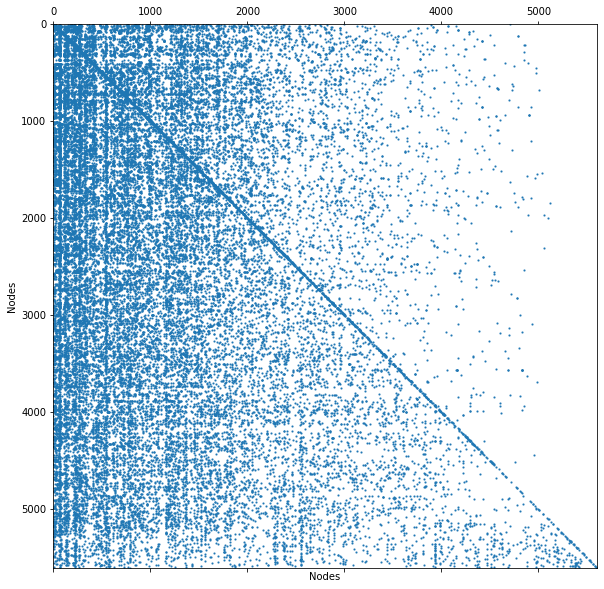

In [28]:
A = nx.adjacency_matrix(graph)
plt.figure(figsize=(10,10))
ax1 = plt.spy(A, precision = 0, markersize = 1)
plt.xlabel("Nodes")
plt.ylabel("Nodes")

This is quite useful though it displays a property which was quite unexpected, like a solid main diagonal (our graph was checked for self loops and none were found). We, thankfully, do observe that A is non-symmetric, which is one of the hallmarks of a directed graph.

Following the methods outlined here http://sociograph.blogspot.com/2012/11/visualizing-adjacency-matrices-in-python.html we now sort our nodes by genre and find that our adjacency matrix takes on quite a different form.

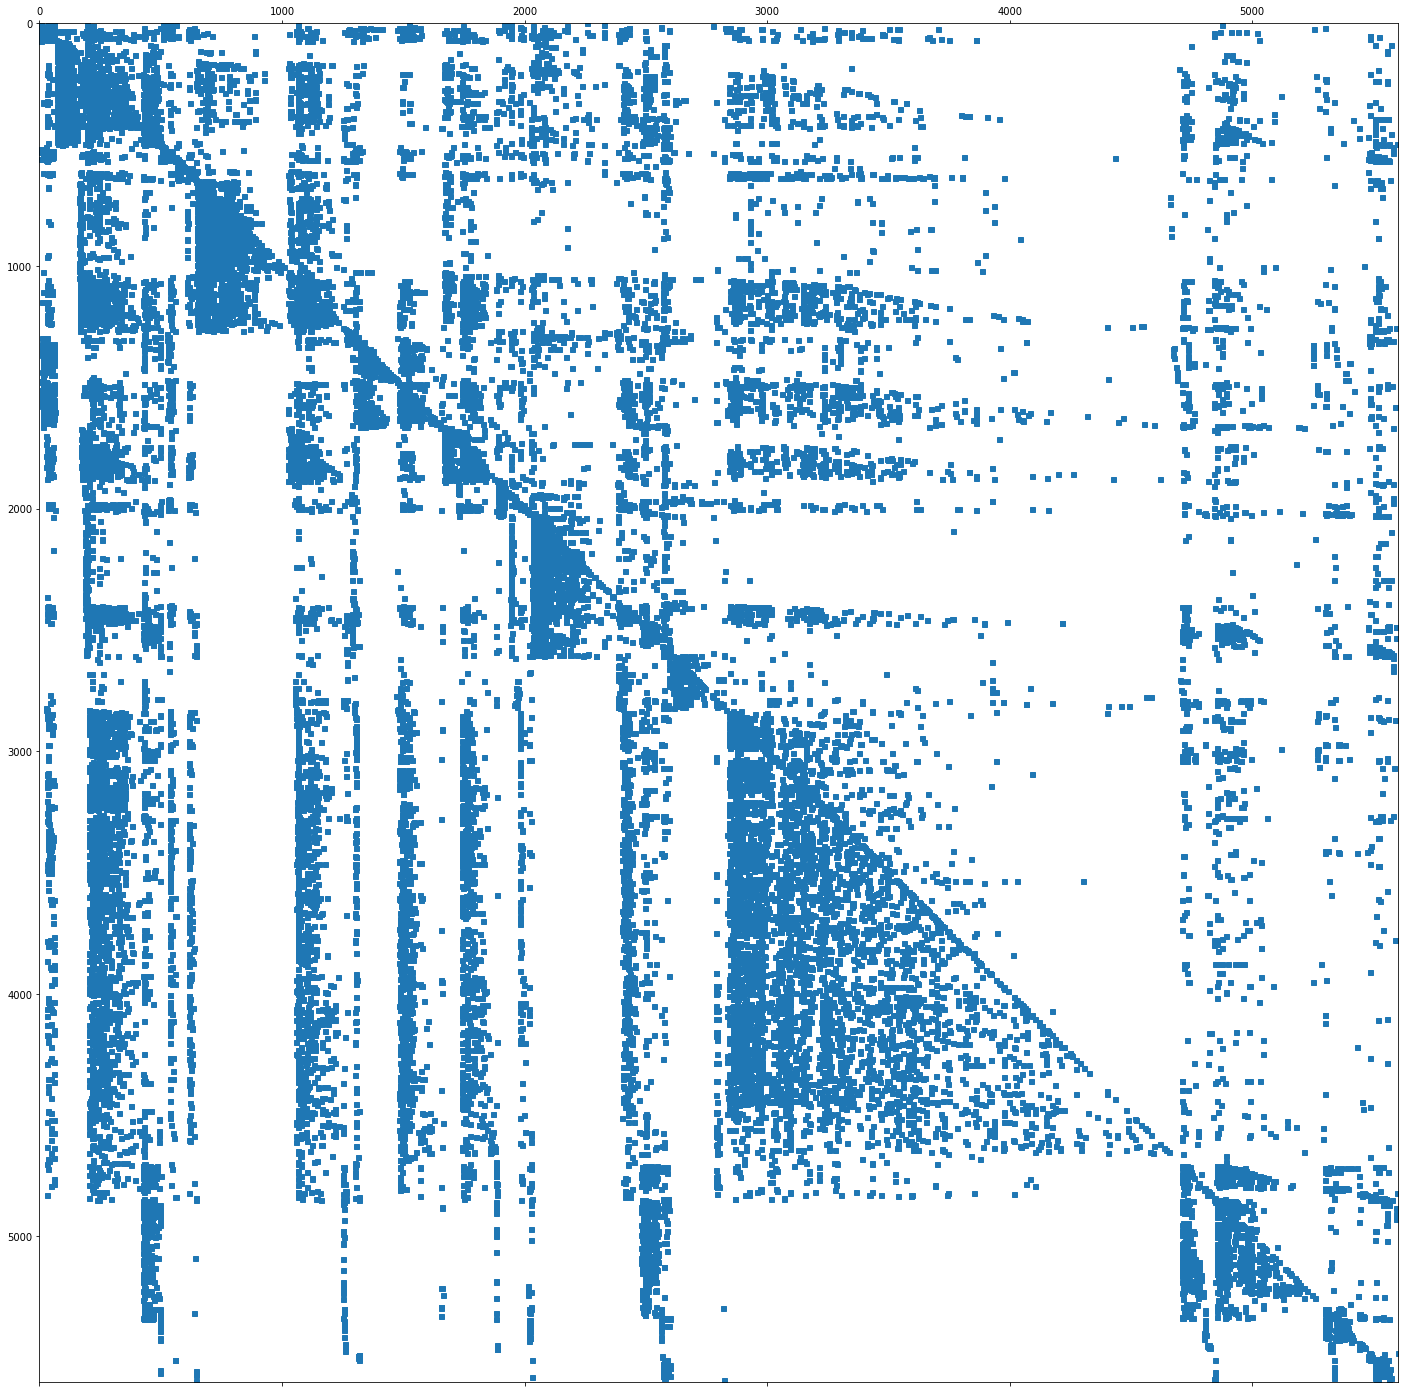

In [31]:
def build_graph_with_edge_attrib(inf_data, artist_data):
    """
    Returns the directed graph of artistic influeence taken from influence_data.csv
       
    Parameters
    ----------
    inf_data : the file influence_data.csv
    arist_data : the file data_by_artist.csv
    
    Returns
    -------
    graph : a NetworkX directed graph

    Notes
    -----
    """
    graph = nx.DiGraph()
    for row in inf_data:
        if graph.has_node(row[0]) is False:	
            graph.add_node(row[0], name = row[1],)
        if graph.has_node(row[4]) is False:
            graph.add_node(row[4], name = row[5])
        if row[2] == row[6]:
            if row[3] == row[7]:
                graph.add_edge(row[4],row[0], genre = row[2], active_start = row[3])
            if row[3] > row[7]:
                graph.add_edge(row[4],row[0], genre = row[2], active_start = row[3]+","+row[7])
            else:
                graph.add_edge(row[4],row[0], genre = row[2], active_start = row[7]+","+row[3])
        else:
            if row[3] == row[7]:
                graph.add_edge(row[4],row[0], genre = row[2]+","+row[6], active_start = row[3])
            if row[3] > row[7]:
                graph.add_edge(row[4],row[0], genre = row[2]+","+row[6], active_start = row[3]+","+row[7])
            else:
                graph.add_edge(row[4],row[0], genre = row[2]+","+row[6], active_start = row[7]+","+row[3])

    return graph

g = build_graph_with_edge_attrib(inf_data, artist_data)

def new_graph(g):
    new_g = nx.DiGraph()
    for a, b, data in sorted(g.edges(data=True), key=lambda x: x[2]['genre']):
        new_g.add_edge(a,b, genre = data['genre'])
        #print('{a} {b} {w}'.format(a=a, b=b, w=data['genre']))
    return new_g

new_g = new_graph(g)

Ag = nx.adjacency_matrix(new_g)
plt.figure(figsize=(25,25))
plt.spy(Ag, markersize = 5)

We now see our nodes "clumping" together by genre. This isn't quite community detection but it does tell us that when we aim a community detection algorithm towards our graph that we should expect communities based on genre. 

We now sort our nodes by start year to find

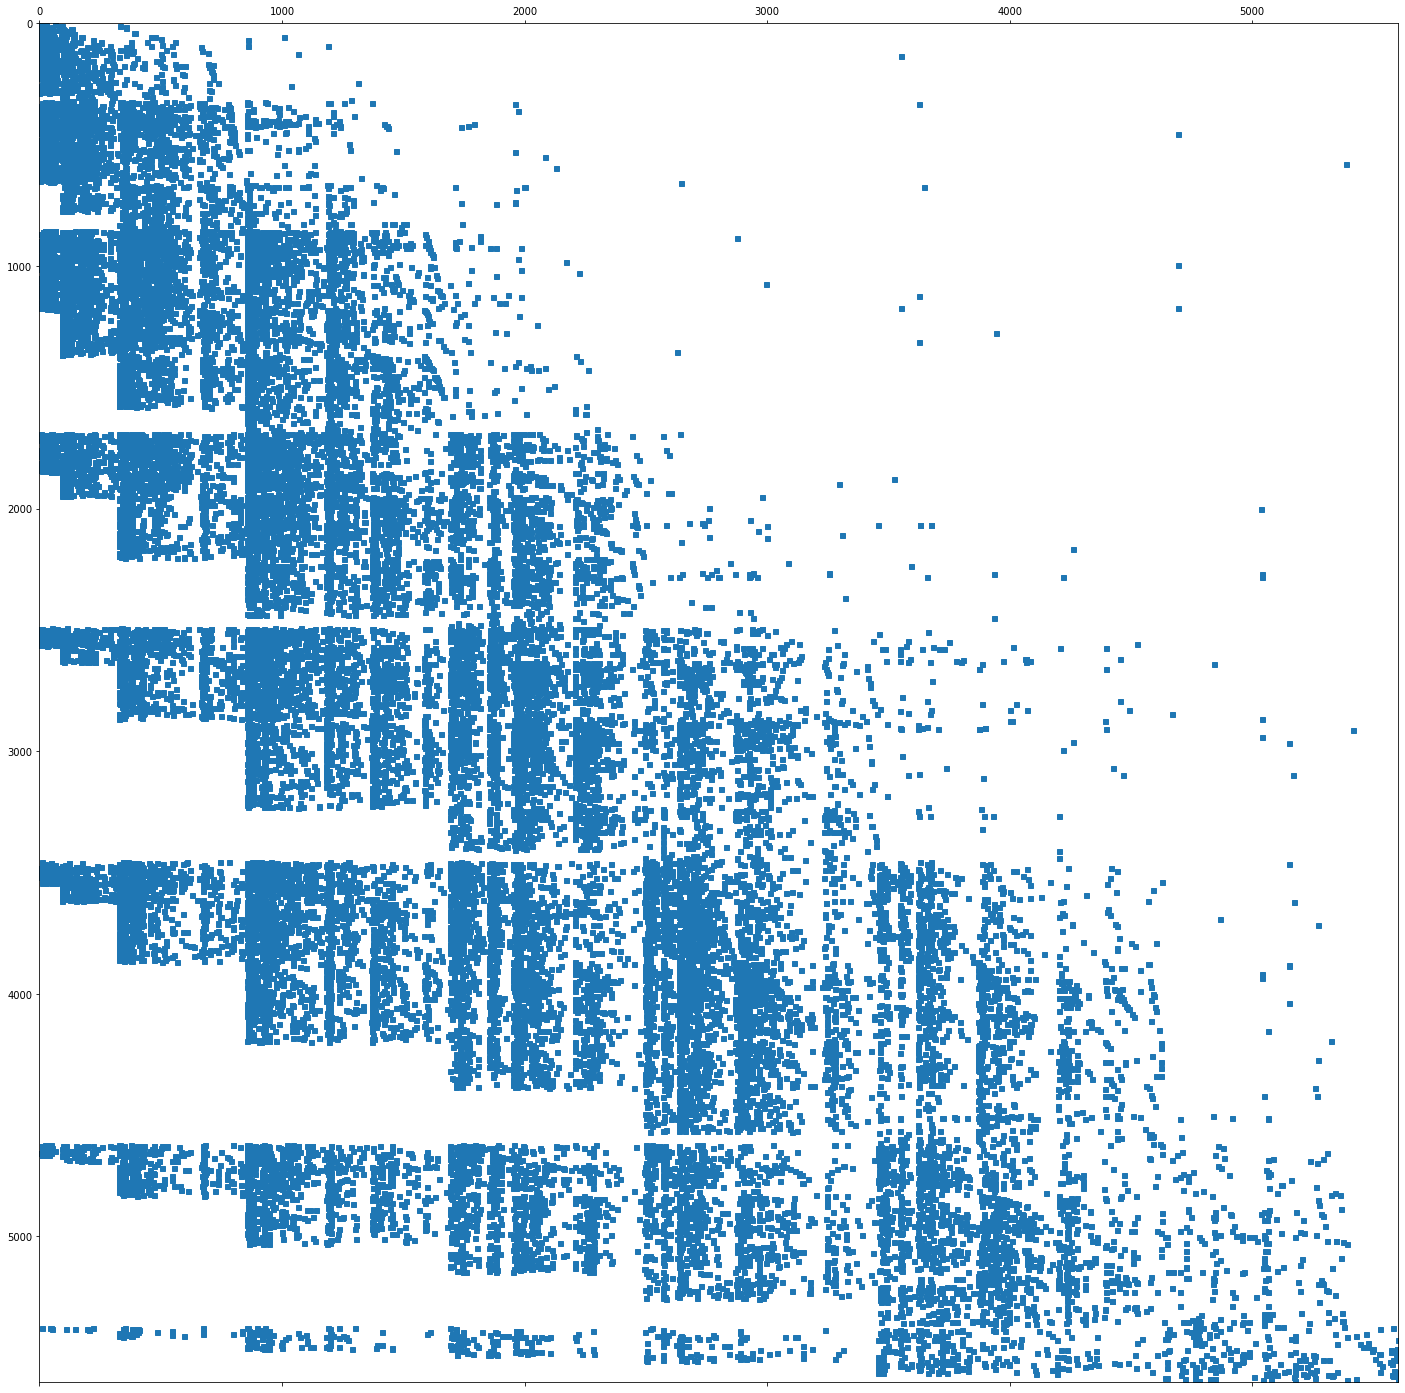

In [33]:
def build_graph_with_edge_attrib(inf_data, artist_data):
    """
    Returns the directed graph of artistic influeence taken from influence_data.csv
       
    Parameters
    ----------
    inf_data : the file influence_data.csv
    arist_data : the file data_by_artist.csv
    
    Returns
    -------
    graph : a NetworkX directed graph

    Notes
    -----
    """
    graph = nx.DiGraph()
    for row in inf_data:
        if graph.has_node(row[0]) is False:	
            graph.add_node(row[0], name = row[1],)
        if graph.has_node(row[4]) is False:
            graph.add_node(row[4], name = row[5])
        if row[2] == row[6]:
            if row[3] == row[7]:
                graph.add_edge(row[4],row[0], active_start = row[3])
            if row[3] > row[7]:
                graph.add_edge(row[4],row[0], active_start = row[3]+","+row[7])
            else:
                graph.add_edge(row[4],row[0], active_start = row[7]+","+row[3])
        else:
            if row[3] == row[7]:
                graph.add_edge(row[4],row[0], active_start = row[3])
            if row[3] > row[7]:
                graph.add_edge(row[4],row[0], active_start = row[3]+","+row[7])
            else:
                graph.add_edge(row[4],row[0], active_start = row[7]+","+row[3])

    return graph

g = build_graph_with_edge_attrib(inf_data, artist_data)

def new_graph(g):
    new_g = nx.DiGraph()
    for a, b, data in sorted(g.edges(data=True), key=lambda x: x[2]['active_start']):
        new_g.add_edge(a,b, genre = data['active_start'])
        #print('{a} {b} {w}'.format(a=a, b=b, w=data['genre']))
    return new_g

new_g = new_graph(g)

Ag = nx.adjacency_matrix(new_g)
plt.figure(figsize=(25,25))
plt.spy(Ag, markersize = 5)

And observe again a tight clustering edges, indicating that the artist's start decade is likely to influence community membership.

## An aside on genre

Genre has been a bit of sticking point in our analysis. Here we take a look at our graph and find the number of edges that exist between two artists of differing genre.

In [24]:
def out_of_genre_influence(inf_data):
    out_of_genre_counter = 0
    total_row_counter = 0
    for row in inf_data:
        total_row_counter += 1
        if row[2] != row[6]:
            out_of_genre_counter += 1
    percent_diff_genre = (out_of_genre_counter/total_row_counter) * 100
    print("We have a total of " + str(total_row_counter) + " edges.")
    print("Of these edges " + str(out_of_genre_counter) + " exist between artists of different genres.")
    print("We see that " + str(percent_diff_genre) + " percent of our edges occur between artists of different genres.")

In [25]:
out_of_genre_influence(inf_data)

We have a total of 42770 edges.
Of these edges 10017 exist between artists of different genres.
We see that 23.42062193126023 percent of our edges occur between artists of different genres.
